In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, auc, f1_score, roc_curve

In [ ]:
df = pd.read_csv('../data/cleaned_tweets.csv')
# some tweets only contained stop words or mentions so are null
# --> change to empty string
df['cleaned_tweet'] = np.where(df.cleaned_tweet.isnull(), '', df.cleaned_tweet)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
# columns to keep for training
keep = ['airline_sentiment', 'cleaned_tweet', 'length', 'capitals', 'cap_length_ratio',
       'n_words', 'n_happy', 'n_sad', 'n_exclamations', 'n_questions']
df = df[keep].copy()
df.head()

In [ ]:
X = df.cleaned_tweet
y = df.airline_sentiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## Naive Bayes

In [8]:
steps = [('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6823746823746824

## Random Forest

In [9]:
# TFIDF
steps = [('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=18))]
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7521367521367521

In [10]:
# CountVectorizer
cv_steps = [('vectorizer', CountVectorizer()), ('clf', RandomForestClassifier(random_state=18))]
cv_pipe = Pipeline(cv_steps)
cv_pipe.fit(X_train, y_train)
cv_pipe.score(X_test, y_test)

0.7535227535227536

### Hyperparameter Tuning

In [ ]:
steps = [('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(random_state=18))]
pipe = Pipeline(steps)

parameters = {
    'tfidf__max_df': np.arange(0.6, 1, .15),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__n_estimators': range(200, 2200, 200),
    'clf__min_samples_split': [0.001, 0.01, 0.1],
    'clf__min_samples_leaf': [0.001, 0.01, 0.1, 1]
}
gs = RandomizedSearchCV(pipe, parameters, cv=5)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

In [ ]:
steps = [('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_df=0.6)),
         ('clf', RandomForestClassifier(random_state=18, min_samples_split=0.01))]
pipe = Pipeline(steps)

parameters = {
    'clf__n_estimators': range(1500, 1800, 100),
    'clf__class_weight': ['balanced', 'balanced_subsample', None],
    'clf__max_features': ['auto', 'sqrt', 'log2']
}
gs = RandomizedSearchCV(pipe, parameters, cv=5)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

In [ ]:
steps = [('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.6)), 
         ('clf', RandomForestClassifier(random_state=18, n_estimators=1500,
                                        max_features='log2', class_weight='balanced_subsample',
                                        min_samples_split=0.001))]
pipe = Pipeline(steps)

In [ ]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

### Final Model

In [11]:
X = df.drop('airline_sentiment', axis=1)
y = df.airline_sentiment

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [13]:
train_num = X_train.drop('cleaned_tweet', axis=1).reset_index(drop=True)
train_text = X_train.cleaned_tweet

tfidf = TfidfVectorizer(max_df=0.6, ngram_range=(1,2))
train_matrix = tfidf.fit_transform(train_text)
train_text_df = pd.DataFrame(train_matrix.toarray(), columns=tfidf.get_feature_names())
train_df = pd.concat([train_num, train_text_df], axis=1)

In [42]:
clf = RandomForestClassifier(random_state=18, class_weight='balanced_subsample',
                            min_samples_split=0.001) #n_estimators=1500,
                            #max_features='log2'
clf.fit(train_df, y_train.reset_index(drop=True)) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.001, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=18, verbose=0, warm_start=False)

In [43]:
test_num = X_test.drop('cleaned_tweet', axis=1).reset_index(drop=True)
test_text = X_test.cleaned_tweet

test_matrix = tfidf.transform(test_text)
test_text_df = pd.DataFrame(test_matrix.toarray(), columns=tfidf.get_feature_names())
test_df = pd.concat([test_num, test_text_df], axis=1)

In [44]:
clf.score(test_df, y_test.reset_index(drop=True))

0.7703857703857704

In [17]:
y_pred = clf.predict(test_df)

In [18]:
y_pred_proba = clf.predict_proba(test_df)
roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovo')

0.8635231187479077

In [21]:
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()

for i, c in enumerate(clf.classes_):
    y_test_temp = np.where(y_test == c, 1, 0)
    fpr[c], tpr[c], thresholds[c] = roc_curve(y_test_temp, y_pred_proba[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

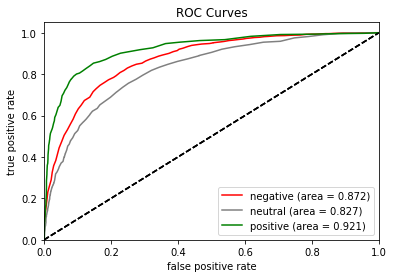

In [24]:
d = {'negative': 'red',
    'neutral': 'grey',
    'positive': 'green'}

for i, c in enumerate(clf.classes_):
    plt.plot(fpr[c], tpr[c], label=f'{c} (area = {round(roc_auc[c], 3)})', color=d[c])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")

# plt.savefig(f'../docs/img/roc.png', dpi=300, bbox_inches='tight')

In [25]:
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=clf.classes_,
             index=clf.classes_)

Confusion Matrix:


,negative,neutral,positive
negative,2592,104,29
neutral,516,351,50
positive,275,70,342


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.77      0.95      0.85      2725
     neutral       0.67      0.38      0.49       917
    positive       0.81      0.50      0.62       687

    accuracy                           0.76      4329
   macro avg       0.75      0.61      0.65      4329
weighted avg       0.75      0.76      0.74      4329



In [45]:
pickle.dump(tfidf, open('../models/tfidf.pkl', 'wb'))
pickle.dump(clf, open('../models/model.pkl', 'wb'))